In [ ]:
# Extension to automatically reload modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from sklearn.preprocessing import PolynomialFeatures, \
    MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, \
    f_regression, RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from models import TrivialSystem
from transforms import BinaryEncoder, RemoveFeatures, \
    IdentityTransform
np.random.seed(43)

In [4]:
NUM_FEATURES_TO_SELECT = 10
PLOTS_FOLDER = "plots/goal1/"

In [5]:
# list to store the names of the features
feature_names = ["school", "sex", "age", "address", "famsize", "Pstatus",
                 "Medu", "Fedu", "Mjob", "Fjob", "reason", "guardian",
                 "traveltime", "studytime", "failures", "schoolsup", "famsup",
                 "paid", "activities", "nursery", "higher", "internet", "romantic",
                 "famrel", "freetime", "goout", "Dalc", "Walc", "health", "absences",]

feature_names = np.array(feature_names)

In [6]:
# Read the training and testing sets
datapoints, labels, feature_info, categories = utils.read_data(
    "datasets/student_performance_train.csv",
    "datasets/student_performance_feature.txt")
test_data, test_labels, _, _ = utils.read_data(
    "datasets/student_performance_test.csv",
    "datasets/student_performance_feature.txt")

labels_g1 = labels[:, 0].copy()
test_labels_g1 = test_labels[:, 0].copy()

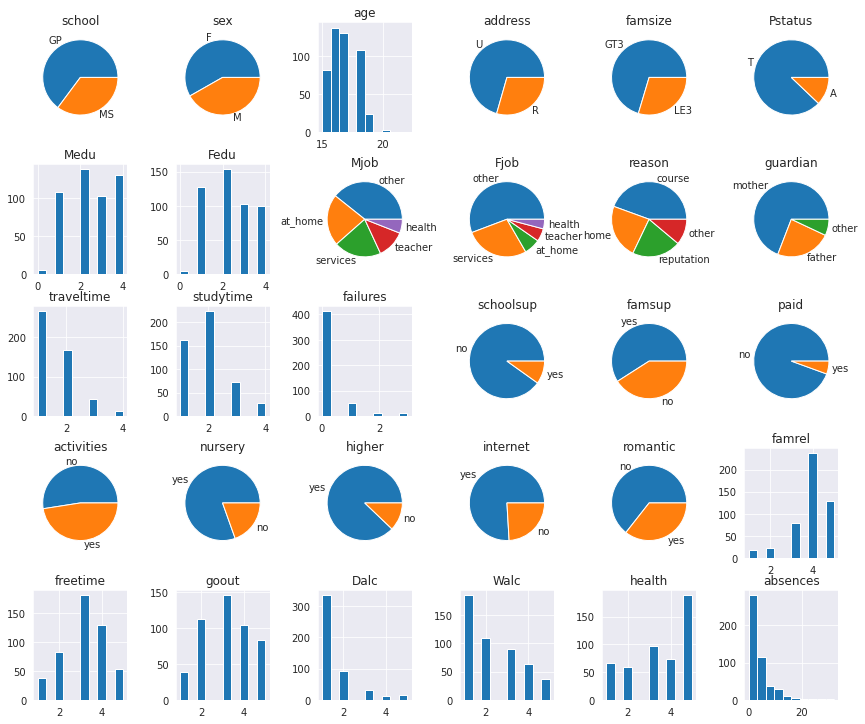

In [7]:
num_features = datapoints.shape[1]

fig, _ = plt.subplots(5, 6)
fig.set_size_inches(12, 10)
fig.tight_layout()

for i in range(num_features):
    if feature_info[i] in ["nominal", "binary"]:
        plt.sca(fig.axes[i])
        pd.Series(datapoints[:, i]).value_counts().plot.pie()
        fig.axes[i].axis('off')
    else:
        fig.axes[i].hist(datapoints[:, i])
    fig.axes[i].set_title(feature_names[i])

plt.savefig("plots/goal1/data_distribution.png", dpi=100)

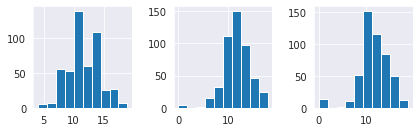

In [8]:
num_targets = labels.shape[1]

fig, _ = plt.subplots(1, 3)
fig.set_size_inches(6, 2)
fig.tight_layout()

for i in range(num_targets):
    fig.axes[i].hist(labels[:, i])
plt.savefig("plots/goal1/targets.png", dpi=100)
plt.show()

In [9]:
# Define a column transformer to
# 1) Encode binary features
# 2) Remove categorical features
# 3) The FunctionTransformer() is just for retaining numeric features as is

ct = ColumnTransformer([
    ("BinaryEncoder", BinaryEncoder(),
     np.where(feature_info == "binary")[0]),
    ("Identity",
     IdentityTransform(),
     np.where(feature_info == "numeric")[0]),
    ("RemoveNominal", RemoveFeatures(),
     np.where(feature_info == "nominal")[0]),
])

## Trivial Regressor - Goal 1

0.0
Root Mean Square Error: 2.840417947729387
Mean Absolute Error: 2.244136433638819
R-Squared score: -2.0224962149484327e-08


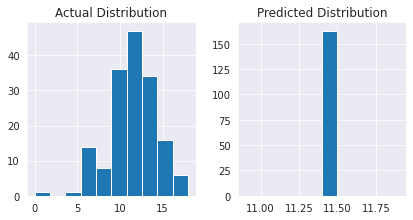

In [10]:
pipe = Pipeline([
    ("Preprocessor", ct),
    ("TrivialRegressor", TrivialSystem())
])

pipe.fit(datapoints, labels_g1)
print(pipe.score(datapoints, labels_g1))
y_pred = pipe.predict(test_data)
utils.report_metrics(test_labels_g1, y_pred)
plt.savefig(f"{PLOTS_FOLDER}/trivial_reg.png")

## 1NN - Goal 1

1.0
Root Mean Square Error: 3.224712856385041
Mean Absolute Error: 2.3865030674846626
R-Squared score: -0.2888952126815887


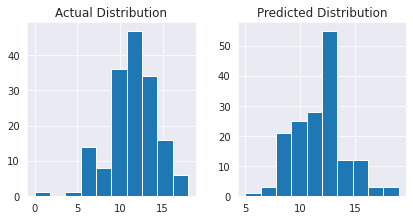

In [11]:
pipe = Pipeline([
    ("Preprocessor", ct),
    ("KNNRegression", KNeighborsRegressor(n_neighbors=1)),
])

pipe.fit(datapoints, labels_g1)
print(pipe.score(datapoints, labels_g1))
y_pred = pipe.predict(test_data)
utils.report_metrics(test_labels_g1, y_pred)
plt.savefig(f"{PLOTS_FOLDER}/1nn_reg.png")

## Linear Regression - Goal 1

0.36360698602152164
Root Mean Square Error: 2.4208207161697577
Mean Absolute Error: 1.8632000597835148
R-Squared score: 0.2736252034516081


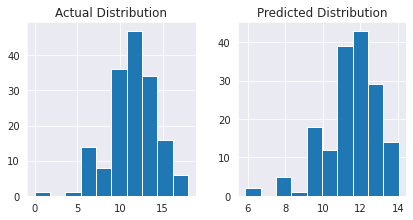

In [12]:
pipe = Pipeline([
    ("Preprocessor", ct),
    ("LinearRegression", LinearRegression()),
])

pipe.fit(datapoints, labels_g1)
with np.printoptions(precision=2, suppress=True):
    print(pipe.score(datapoints, labels_g1))
y_pred = pipe.predict(test_data)
utils.report_metrics(test_labels_g1, y_pred)
plt.savefig(f"{PLOTS_FOLDER}/linear_reg.png")

## Feature Engineering

In [13]:
ct = ColumnTransformer([
    ("BinaryEncoder", BinaryEncoder(),
     np.where(feature_info == "binary")[0]),
    ("Identity",
     IdentityTransform(),
     np.where(feature_info == "numeric")[0]),
    ("OneHotEncoder", OneHotEncoder(),
     np.where(feature_info == "nominal")[0])
])

ct.fit(datapoints)
datapoints_pp = ct.transform(datapoints)
datapoints_pp.shape

(486, 43)

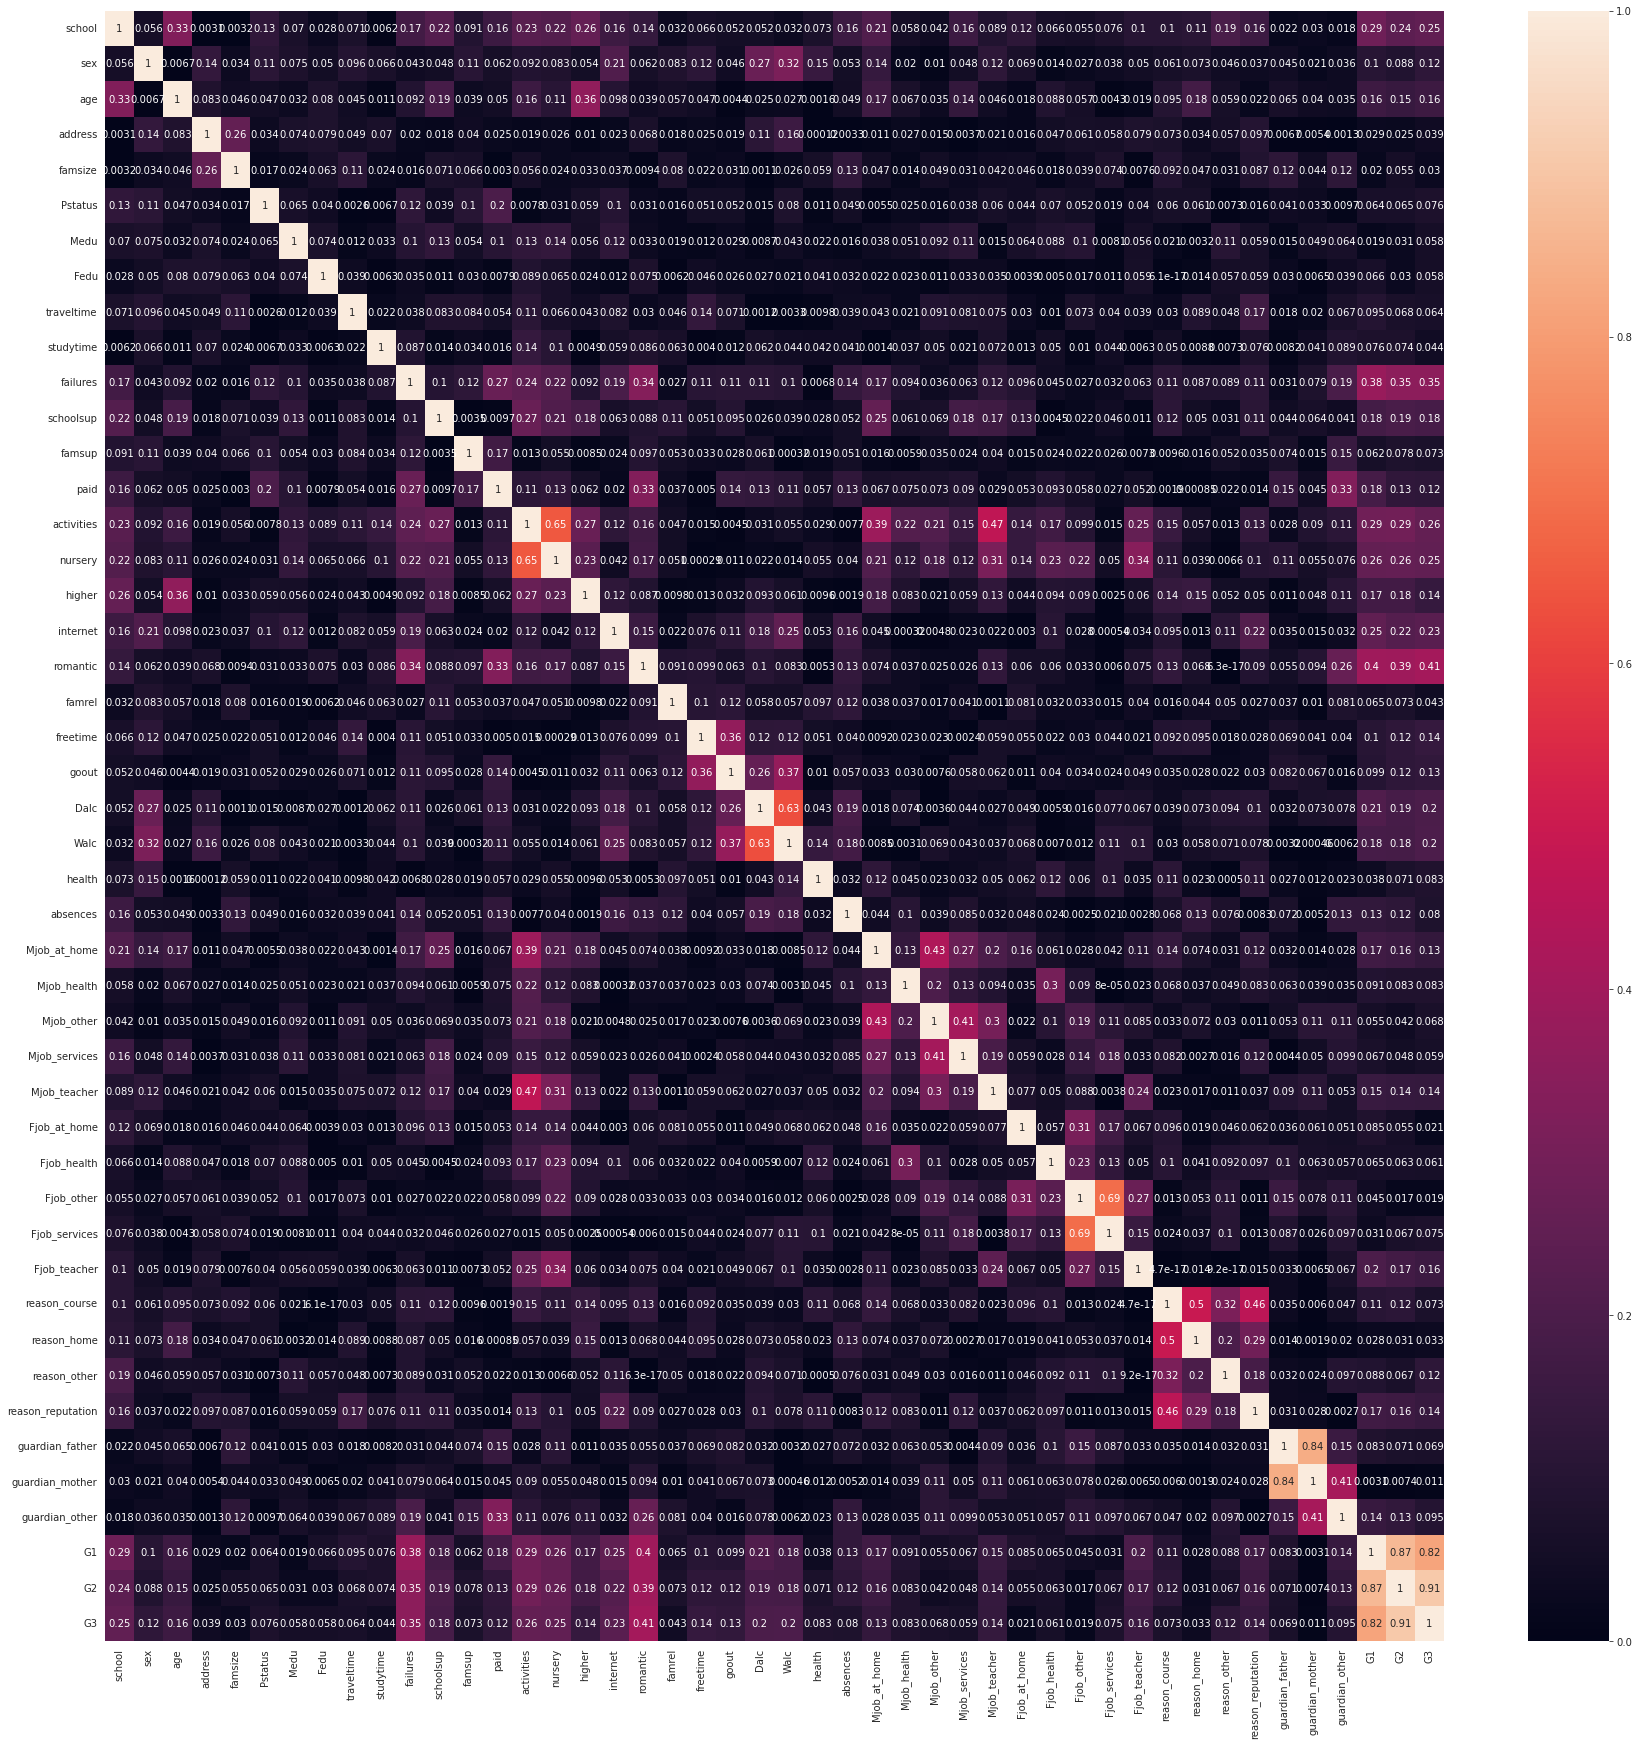

In [14]:
# Create a figure
fig = plt.figure()
fig.set_size_inches(30, 30)

# Create an array to store all the data
all_data = np.append(datapoints_pp, labels, axis=1)

# Calculate correlation between all the features and the output
# and get the absolute value of the correlation
corr = np.corrcoef(all_data.astype(float), rowvar=False)
p_corr = abs(corr)

axis_names = np.append(feature_names[feature_info != "nominal"],
                       ct.transformers_[2][1].get_feature_names(
                           feature_names[feature_info == "nominal"]))
axis_names = np.append(axis_names, ["G1", "G2", "G3"])

# Plot a heatmap of the correlation
sns.heatmap(p_corr, annot=p_corr,
            xticklabels=axis_names,
            yticklabels=axis_names,)
plt.savefig("plots/goal1/corr_mat.png", dpi=100)

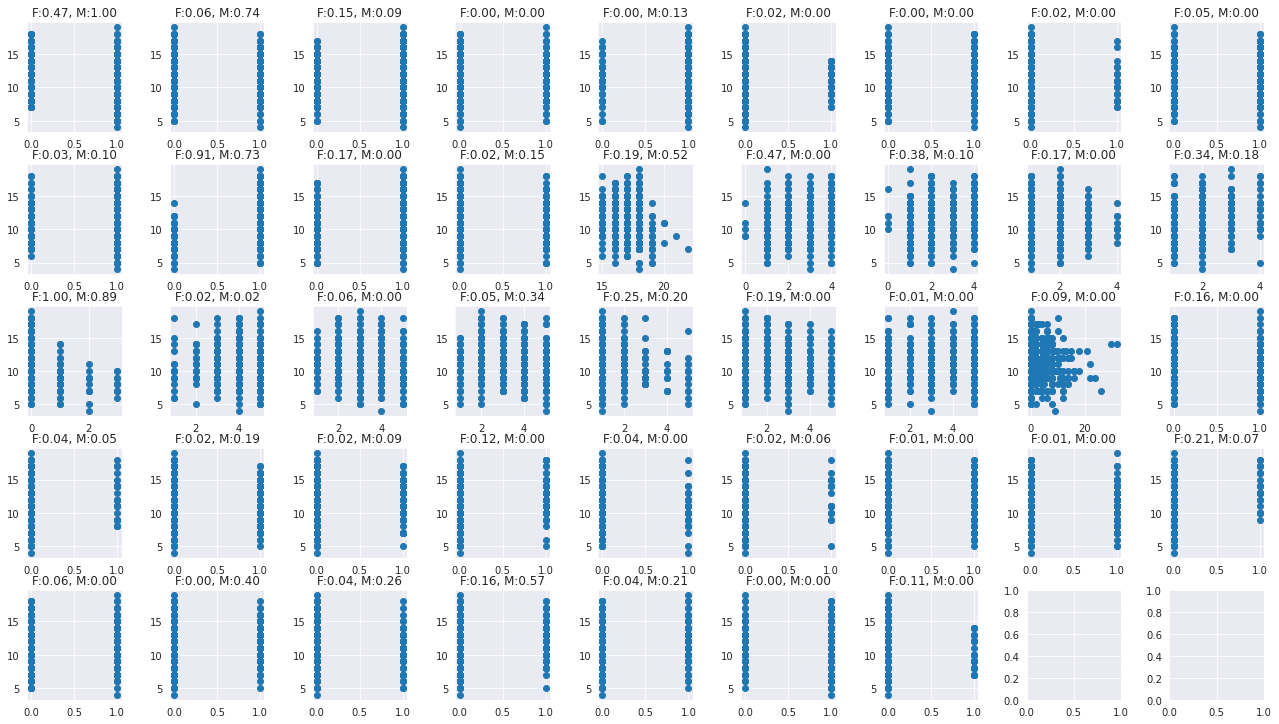

In [15]:
# Plot each feature with the output with f_regression score and mutual information score
_ = utils.get_information_plots(datapoints_pp, labels_g1)

In [16]:
# Top 10 features with the highest correlation with the output
top_corr_features = np.argsort(p_corr[:-3, -3])[::-1]
print(axis_names[top_corr_features][:NUM_FEATURES_TO_SELECT])
print(sorted(top_corr_features[:NUM_FEATURES_TO_SELECT]))

['romantic' 'failures' 'activities' 'school' 'nursery' 'internet' 'Dalc'
 'Fjob_teacher' 'Walc' 'paid']
[0, 10, 13, 14, 15, 17, 18, 22, 23, 35]


In [17]:
# Select features based on f_regression score
skb_f = SelectKBest(score_func=f_regression, k=NUM_FEATURES_TO_SELECT)
skb_f.fit(datapoints_pp, labels_g1)
print(axis_names[skb_f.get_support(indices=True)])
print(skb_f.get_support(indices=True))

['school' 'failures' 'paid' 'activities' 'nursery' 'internet' 'romantic'
 'Dalc' 'Walc' 'Fjob_teacher']
[ 0 10 13 14 15 17 18 22 23 35]


In [18]:
# Select features based on f_regression score
skb_m = SelectKBest(score_func=utils.mutual_info_regression_seeded,
                    k=NUM_FEATURES_TO_SELECT)
skb_m.fit(datapoints_pp, labels_g1)
print(axis_names[skb_m.get_support(indices=True)])
print(skb_m.get_support(indices=True))

['school' 'sex' 'failures' 'paid' 'romantic' 'goout' 'reason_home'
 'reason_other' 'reason_reputation' 'guardian_father']
[ 0  1 10 13 18 21 37 38 39 40]


In [19]:
# RFECV using LinearRegression
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=5,
                 min_features_to_select=NUM_FEATURES_TO_SELECT)
selector.fit(datapoints_pp, labels[:, 0])
print(axis_names[selector.get_support(indices=True)])
print(selector.get_support(indices=True))

['school' 'sex' 'Pstatus' 'failures' 'schoolsup' 'internet' 'romantic'
 'Mjob_health' 'Fjob_teacher' 'reason_reputation' 'guardian_father']
[ 0  1  5 10 11 17 18 27 35 39 40]


### Cross Validation to determine the number of features to select

100%|██████████| 28/28 [00:02<00:00, 12.90it/s]


7 [0.22641178 0.2463303  0.23747284 0.22533031 0.39306958]
Root Mean Square Error: 2.4484454001468383
Mean Absolute Error: 1.868515924555019
R-Squared score: 0.2569528717831707


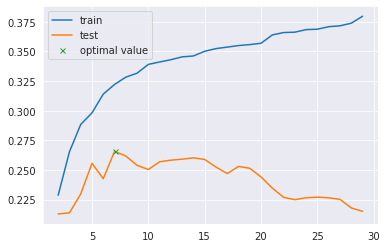

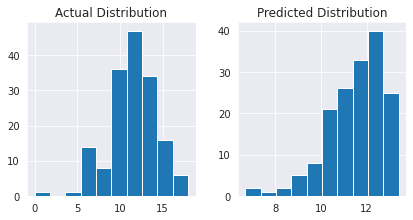

In [20]:
search_space = range(2, 30, 1)

ct = ColumnTransformer([
    ("BinaryEncoder", BinaryEncoder(),
     np.where(feature_info == "binary")[0]),
    ("Identity",
     IdentityTransform(),
     np.where(feature_info == "numeric")[0]),
    ("OneHotEncoder", OneHotEncoder(),
     np.where(feature_info == "nominal")[0]),
])

pipe = lambda k: Pipeline([
    ("Preprocessor", ct),
    ("skb", SelectKBest(score_func=f_regression, k=k)),
    ("LinearRegression", LinearRegression()),
])

ms = utils.ModelSelector(pipeline=pipe)
cv_output, k, fig = ms.fit(datapoints, labels_g1, search_space)
print(k, cv_output["test_score"])
y_pred = ms.get_best_estimator().predict(test_data)
utils.report_metrics(test_labels_g1, y_pred)
fig.savefig(f"{PLOTS_FOLDER}/cv_feature_select.png")

### Cross Validation to determine the optimal number of neighbors for KNN Regression

100%|██████████| 28/28 [00:02<00:00,  9.88it/s]


26 [0.14327098 0.24089576 0.23576217 0.16742981 0.35295008]
[ 0 10 14 15 17 18 22]
Root Mean Square Error: 2.532136355780947
Mean Absolute Error: 1.9424256724870224
R-Squared score: 0.20528814788687033


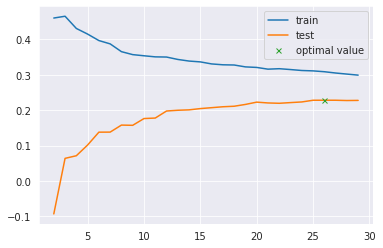

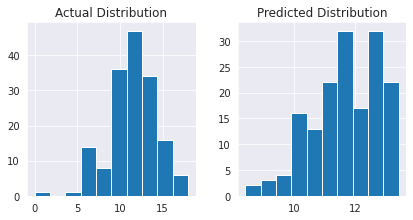

In [21]:
search_space = range(2, 30, 1)

ct = ColumnTransformer([
    ("BinaryEncoder", BinaryEncoder(),
     np.where(feature_info == "binary")[0]),
    ("Identity",
     IdentityTransform(),
     np.where(feature_info == "numeric")[0]),
    ("OneHotEncoder", OneHotEncoder(),
     np.where(feature_info == "nominal")[0]),
])

pipe = lambda k: Pipeline([
    ("Preprocessor", ct),
    ("skb", SelectKBest(score_func=f_regression, k=7)),
    ("MinMax", MinMaxScaler()),
    ("KNN", KNeighborsRegressor(n_neighbors=k,
                                weights="uniform")),
])

ms = utils.ModelSelector(pipeline=pipe)
cv_output, k, fig = ms.fit(datapoints, labels_g1, search_space)
fig.savefig(f"{PLOTS_FOLDER}/knn_reg_cv.png")
print(k, cv_output["test_score"])
print(ms.get_best_estimator()[1].get_support(indices=True))
y_pred = ms.get_best_estimator().predict(test_data)
utils.report_metrics(test_labels_g1, y_pred)
plt.savefig(f"{PLOTS_FOLDER}/knn_reg.png")

### Grid Search and Cross Validation to determine C and epsilon for SVR

100%|██████████| 36/36 [00:06<00:00,  5.36it/s]


2.5 [0.26955631 0.2354084  0.19643744 0.20720517 0.36549745]
Root Mean Square Error: 2.414765374011408
Mean Absolute Error: 1.7917007851076525
R-Squared score: 0.2772545072243944


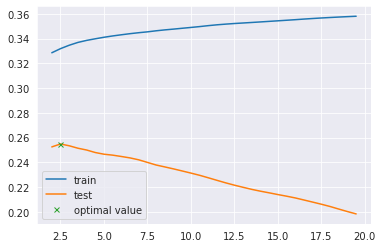

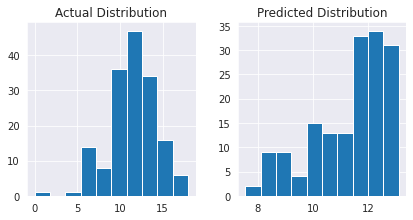

In [22]:
search_space = np.arange(2, 20, 0.5)

ct = ColumnTransformer([
    ("BinaryEncoder", BinaryEncoder(),
     np.where(feature_info == "binary")[0]),
    ("Identity",
     IdentityTransform(),
     np.where(feature_info == "numeric")[0]),
    ("OneHotEncoder", OneHotEncoder(),
     np.where(feature_info == "nominal")[0]),
])

pipe = lambda k: Pipeline([
    ("Preprocessor", ct),
    ("skb", SelectKBest(score_func=f_regression, k=5)),
    ("SVR", SVR(C=k, kernel="rbf")),
])

ms = utils.ModelSelector(pipeline=pipe)
cv_output, k, fig = ms.fit(datapoints, labels_g1, search_space)
fig.savefig(f"{PLOTS_FOLDER}/cv_svr.png")
print(k, cv_output["test_score"])
y_pred = ms.get_best_estimator().predict(test_data)
utils.report_metrics(test_labels_g1, y_pred)
plt.savefig(f"{PLOTS_FOLDER}/svr_1.png")

In [23]:
ct = ColumnTransformer([
    ("BinaryEncoder", BinaryEncoder(),
     np.where(feature_info == "binary")[0]),
    ("Identity",
     IdentityTransform(),
     np.where(feature_info == "numeric")[0]),
    ("OneHotEncoder", OneHotEncoder(),
     np.where(feature_info == "nominal")[0]),
])

pipe = Pipeline([
    ("Preprocessor", ct),
    ("skb", SelectKBest(score_func=f_regression, k=7)),
    ("SVR", SVR()),
])

# Define parameters for grid search
parameters = {"SVR__C":np.arange(10, 20, 0.5),
              "SVR__epsilon":[0.01, 0.1],
              "SVR__kernel":["rbf", "linear", "poly"]}
gs = GridSearchCV(pipe, parameters, refit=True)
gs.fit(datapoints, labels_g1)

GridSearchCV(estimator=Pipeline(steps=[('Preprocessor',
                                        ColumnTransformer(transformers=[('BinaryEncoder',
                                                                         BinaryEncoder(),
                                                                         array([ 0,  1,  3,  4,  5, 15, 16, 17, 18, 19, 20, 21, 22])),
                                                                        ('Identity',
                                                                         IdentityTransform(),
                                                                         array([ 2,  6,  7, 12, 13, 14, 23, 24, 25, 26, 27, 28, 29])),
                                                                        ('OneHotEncoder',
                                                                         OneHotEncoder(),
                                                                         array([ 8,  9, 10, 11]))])),
                                 

Best parameters for SVR grid search {'SVR__C': 19.0, 'SVR__epsilon': 0.01, 'SVR__kernel': 'linear'}
Root Mean Square Error: 2.434733460570774
Mean Absolute Error: 1.843964367018643
R-Squared score: 0.265252087156694


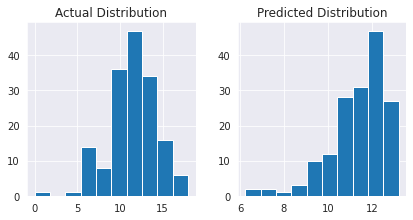

In [24]:
print("Best parameters for SVR grid search", gs.best_params_)
y_pred = gs.best_estimator_.predict(test_data)
utils.report_metrics(test_labels_g1, y_pred)
plt.savefig(f"{PLOTS_FOLDER}/svr_2.png")

### Cross Validation to find the number of hidden neurons in an MLP

100%|██████████| 19/19 [00:23<00:00,  1.23s/it]


140 [0.25618748 0.20935071 0.25855381 0.1786087  0.40163917]
Root Mean Square Error: 2.4656796156942424
Mean Absolute Error: 1.895171206617524
R-Squared score: 0.24645567754005882


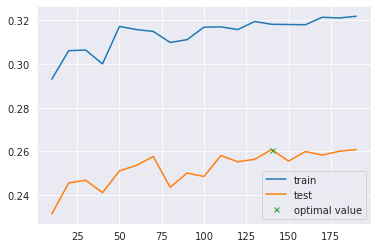

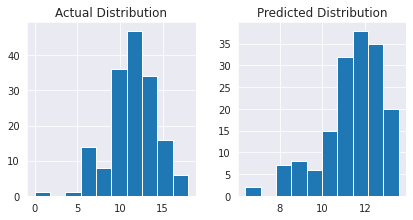

In [25]:
search_space = np.arange(10, 200, 10)

ct = ColumnTransformer([
    ("BinaryEncoder", BinaryEncoder(),
     np.where(feature_info == "binary")[0]),
    ("Identity",
     IdentityTransform(),
     np.where(feature_info == "numeric")[0]),
    ("OneHotEncoder", OneHotEncoder(),
     np.where(feature_info == "nominal")[0]),
])

pipe = lambda k: Pipeline([
    ("Preprocessor", ct),
    ("skb", SelectKBest(score_func=f_regression, k=7)),
    ("MLP", MLPRegressor(hidden_layer_sizes=(k, ),
                         solver="sgd")),
])

ms = utils.ModelSelector(pipeline=pipe)
cv_output, k, fig = ms.fit(datapoints, labels_g1, search_space)
print(k, cv_output["test_score"])
fig.savefig(f"{PLOTS_FOLDER}/ann_cv.png")
y_pred = ms.get_best_estimator().predict(test_data)
utils.report_metrics(test_labels_g1, y_pred)
plt.savefig(f"{PLOTS_FOLDER}/ann_reg.png")

### Cross Validation to determine alpha value in Ridge Regression

100%|██████████| 116/116 [00:07<00:00, 14.77it/s]


11.5 [0.22407775 0.25114029 0.25389895 0.23692822 0.38091071]
Root Mean Square Error: 2.45725784625858
Mean Absolute Error: 1.876201053379725
R-Squared score: 0.2515944948545431


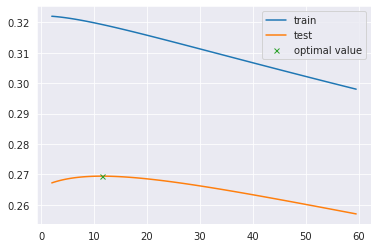

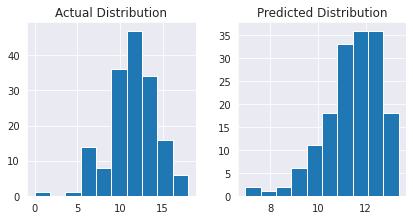

In [26]:
search_space = np.arange(2, 60, 0.5)

ct = ColumnTransformer([
    ("BinaryEncoder", BinaryEncoder(),
     np.where(feature_info == "binary")[0]),
    ("Identity",
     IdentityTransform(),
     np.where(feature_info == "numeric")[0]),
    ("OneHotEncoder", OneHotEncoder(),
     np.where(feature_info == "nominal")[0]),
])

pipe = lambda k: Pipeline([
    ("Preprocessor", ct),
    ("skb", SelectKBest(score_func=f_regression, k=7)),
    ("Ridge", Ridge(alpha=k))
])

ms = utils.ModelSelector(pipeline=pipe)
cv_output, k, fig = ms.fit(datapoints, labels_g1, search_space)
print(k, cv_output["test_score"])
fig.savefig(f"{PLOTS_FOLDER}/ridge_cv.png")
y_pred = ms.get_best_estimator().predict(test_data)
utils.report_metrics(test_labels_g1, y_pred)
plt.savefig(f"{PLOTS_FOLDER}/ridge_reg.png")

In [27]:
ct = ColumnTransformer([
    ("BinaryEncoder", BinaryEncoder(),
     np.where(feature_info == "binary")[0]),
    ("Identity",
     IdentityTransform(),
     np.where(feature_info == "numeric")[0]),
    ("OneHotEncoder", OneHotEncoder(),
     np.where(feature_info == "nominal")[0]),
])

pipe = Pipeline([
    ("Preprocessor", ct),
    ("skb", SelectKBest(score_func=f_regression)),
    ("Ridge", Ridge())
])

parameters = {"skb__k":range(2, 30),
              "Ridge__alpha":np.arange(2, 60, 0.5)}

gs = GridSearchCV(pipe, parameters, refit=True)
gs.fit(datapoints, labels_g1)

GridSearchCV(estimator=Pipeline(steps=[('Preprocessor',
                                        ColumnTransformer(transformers=[('BinaryEncoder',
                                                                         BinaryEncoder(),
                                                                         array([ 0,  1,  3,  4,  5, 15, 16, 17, 18, 19, 20, 21, 22])),
                                                                        ('Identity',
                                                                         IdentityTransform(),
                                                                         array([ 2,  6,  7, 12, 13, 14, 23, 24, 25, 26, 27, 28, 29])),
                                                                        ('OneHotEncoder',
                                                                         OneHotEncoder(),
                                                                         array([ 8,  9, 10, 11]))])),
                                 

In [28]:
gs.best_params_

{'Ridge__alpha': 11.5, 'skb__k': 7}

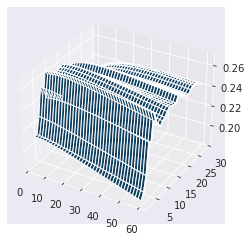

In [29]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(gs.cv_results_["param_Ridge__alpha"].reshape(116, 28),
                gs.cv_results_["param_skb__k"].reshape(116, 28),
                gs.cv_results_["mean_test_score"].reshape(116, 28))
plt.savefig(f"{PLOTS_FOLDER}/ridge_reg_gs.png")

Root Mean Square Error: 2.4619170817387417
Mean Absolute Error: 1.8762746637068248
R-Squared score: 0.24875368321005897


(2.4619170817387417,
 1.8762746637068248,
 0.24875368321005897,
 <Figure size 432x216 with 2 Axes>)

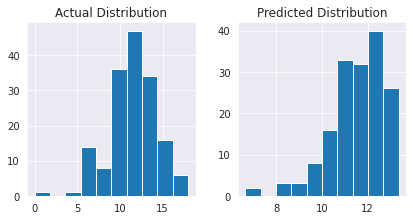

In [30]:
utils.report_metrics(test_labels_g1, gs.best_estimator_.predict(test_data))